In [1]:
# Importing modules
from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
from astropy.cosmology import Planck13
cosmo=Planck13
from astropy . coordinates import Distance
from astropy import units as u
from astropy.table import Table
import pandas as pd
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import random

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [4]:
# Importing Euclid FS2 to DataFrame, and renaming some columns
hdul = fits.open('../Photo_group_project/11401.fits')
data = hdul[1].data
cols = hdul[1].columns
t=Table(data)
df = t.to_pandas()
df = df.rename(columns={"ra_gal": "RA"})
df = df.rename(columns={"dec_gal": "Dec"})
df = df.rename(columns={"observed_redshift_gal": "Z"})
df = df.rename(columns={"rmag": "Rpetro"})
df = df.rename(columns={"halo_id": "HaloID"})
del hdul, data, cols, t

In [5]:
# Magnitude limiting to r<21
df=df[(df['Rpetro']<21)]

In [6]:
# Conversion of flux to magnitude
def flux_to_mag(flux):
    return -2.5 * np.log10(flux) - 48.6

In [7]:
# Applying a 1% error to all fluxes
def apply_random_error(flux):
    error_factor = 0.05  
    noise = np.random.normal(loc=0, scale=error_factor * flux)
    return flux + noise

flux_columns = ['lsst_r', 'lsst_u', 'lsst_g', 'lsst_i', 'lsst_z', 'lsst_y', 
                '2mass_j', '2mass_h', '2mass_ks']


for col in tqdm(flux_columns):
    df[col] = df[col].apply(apply_random_error)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Converting flux to magnitudes
mag_cols=[]

for col in tqdm(flux_columns):
    mag_col = f'mag_{col}'  # New column name for magnitudes
    mag_cols.append(mag_col)
    df[mag_col] = df[col].apply(flux_to_mag)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# Creating X, the array of features needed for photo-z estimate

X=np.zeros((len(df),45))

l=0
for i in tqdm(range(len(mag_cols))):
    for j in range(i+1,len(mag_cols)):
        X[:,l]=(df[mag_cols[i]] - df[mag_cols[j]])
        l+=1
for mag in tqdm(mag_cols):
    X[:,l]=df[mag]
    l+=1

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
# Making of column of 0-N in the dataframe to be used later
df['raw_index']=range(len(df))

In [11]:
# Making dftrain, a small but represnetative subset of the survey
dftrain=df[(df['RA']<185) & (df['Dec']<5)]
dftest=df.copy()

In [12]:
Ntrain=len(dftrain)
Ntest=len(dftest)

In [13]:
# Splitting X up into Xtrain and Xtest
Xtrain=X[dftrain['raw_index']]
Xtest=X

In [14]:
# Scaling Xtrain and Xtest to have 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [15]:
# Extracting spec-z values
Ztrain=dftrain['Z'].values
Ztest=dftest['Z'].values

In [16]:
# Using flexzboost for photo-z
# This cell is training the model using the training data and validation (20% of training)
import flexcode
from flexcode.regression_models import XGBoost
from flexcode.regression_models import NN


n_obs = Xtrain.shape[0]
n_train = round(n_obs * 0.8)
n_validation = n_obs - n_train

perm = np.random.permutation(n_obs)
Xtrain1 = Xtrain[perm[:n_train], :]
Ztrain1 = Ztrain[perm[:n_train]]
x_validation = Xtrain[perm[n_train:]]
z_validation = Ztrain[perm[n_train:]]

# Fit the model
model = flexcode.FlexCodeModel(XGBoost, max_basis=10, basis_system='cosine',
                               regression_params={"max_depth": 8})
model.fit(Xtrain1, Ztrain1)
model.tune(x_validation, z_validation)

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[15:30:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:30:13] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:30:43] WARNING: ../src/objective/regression_

In [18]:
%%time
# This is the prediction phase of the photo-z method.
# The output is cdes, the conditional density estimate (p(z)'s) and z_grid, the possible z solutions
cdes, z_grid = model.predict(Xtest, n_grid=1000)

CPU times: user 9min 42s, sys: 17.8 s, total: 10min
Wall time: 6min 22s


In [19]:
# Creating a copy of cdes for post-processing
cdes_sharp=cdes.copy()

In [20]:
from flexcode import post_processing

In [23]:
%%time
# Optimising the remove bump threshold using cdes and the true Z values
delta_grid=np.logspace(-1,1,50)
post_processing.choose_bump_threshold(cdes[::1000],z_grid,Ztest[::1000],delta_grid)

CPU times: user 57 s, sys: 19.3 ms, total: 57 s
Wall time: 57 s


0.5963623316594643

In [24]:
%%time
# Optimising the sharpening parameter using cdes and the true Z values
alpha_grid=np.logspace(-1,1,50)
post_processing.choose_sharpen(cdes[::1000],z_grid,Ztest[::1000],alpha_grid)

CPU times: user 16.6 s, sys: 1.08 ms, total: 16.6 s
Wall time: 16.6 s


1.2648552168552958

In [25]:
# Applying remove_bumps
for i in tqdm(range(len(cdes_sharp))):
    post_processing._remove_bumps(cdes_sharp[i],0.596)

  0%|          | 0/1101710 [00:00<?, ?it/s]

In [26]:
# Applying sharpen
for i in tqdm(range(len(cdes_sharp))):
    post_processing.sharpen(cdes_sharp[i],1.265)

  0%|          | 0/1101710 [00:00<?, ?it/s]

In [ ]:
#np.save('cdes_sharp',cdes_sharp)

In [ ]:
#np.save('cdes',cdes)

In [ ]:
#np.save('z_grid',z_grid)

In [ ]:
#cdes=np.load('cdes.npy')

In [ ]:
#cdes_sharp=np.load('cdes_sharp.npy')

In [ ]:
#z_grid=np.load('z_grid.npy')

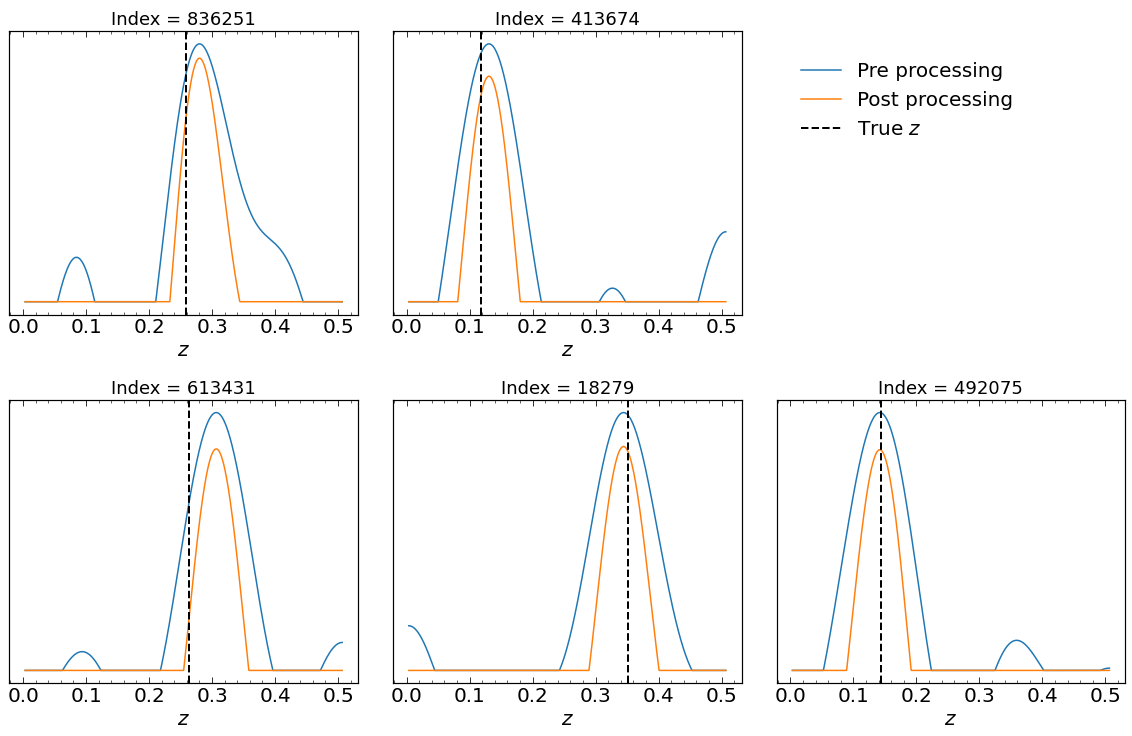

In [28]:
# Plotting some example p(z)'s
import matplotlib
fig = plt.figure(figsize=(20,12))
spec = matplotlib.gridspec.GridSpec(ncols=3, nrows=2) # 6 columns evenly divides both 2 & 3
plt.subplots_adjust(wspace=0.1,hspace=0.3)
ax1 = fig.add_subplot(spec[0,0]) 
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[1,0])
ax4 = fig.add_subplot(spec[1,1]) 
ax5 = fig.add_subplot(spec[1,2])

sample=random.sample(range(len(cdes_sharp)),5)

ii=sample[0]
ax1.plot(z_grid, cdes[ii, :],label='Pre processing')
ax1.plot(z_grid, cdes_sharp[ii, :],label='Post processing')
ax1.axvline(np.array(df[df['raw_index']==ii]['Z'])[0], color="k",label='True ' +'$z$',linewidth=2,linestyle='dashed')
ax1.set_yticks([])
ax1.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax1.set_xlabel('$z$')
ax1.set_title('Index = '+str(df['raw_index'].iloc[ii]),fontsize=18)

ii=sample[1]
ax2.plot(z_grid, cdes[ii, :])
ax2.plot(z_grid, cdes_sharp[ii, :])
ax2.axvline(np.array(df[df['raw_index']==ii]['Z'])[0], color="k",linewidth=2,linestyle='dashed')
ax2.set_yticks([])
ax2.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax2.set_xlabel('$z$')
ax2.set_title('Index = '+str(df['raw_index'].iloc[ii]),fontsize=18)




ii=sample[2]
ax3.plot(z_grid, cdes[ii, :])
ax3.plot(z_grid, cdes_sharp[ii, :])
ax3.axvline(np.array(df[df['raw_index']==ii]['Z'])[0], color="k",linewidth=2,linestyle='dashed')
ax3.set_yticks([])
ax3.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax3.set_xlabel('$z$')
ax3.set_title('Index = '+str(df['raw_index'].iloc[ii]),fontsize=18)



ii=sample[3]
ax4.plot(z_grid, cdes[ii, :])
ax4.plot(z_grid, cdes_sharp[ii, :])
ax4.axvline(np.array(df[df['raw_index']==ii]['Z'])[0], color="k",linewidth=2,linestyle='dashed')
ax4.set_yticks([])
ax4.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax4.set_xlabel('$z$')
ax4.set_title('Index = '+str(df['raw_index'].iloc[ii]),fontsize=18)



ii=sample[4]
ax5.plot(z_grid, cdes[ii, :])
ax5.plot(z_grid, cdes_sharp[ii, :])
ax5.axvline(np.array(df[df['raw_index']==ii]['Z'])[0], color="k",linewidth=2,linestyle='dashed')
ax5.set_yticks([])
ax5.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax5.set_xlabel('$z$')
ax5.set_title('Index = '+str(df['raw_index'].iloc[ii]),fontsize=18)



fig.legend(loc=(0.7,0.8),frameon=False)

plt.savefig('plots/p_z.jpg',bbox_inches='tight',dpi=200)

plt.show()

In [67]:
# Finding the peak (mode) of each p(z) and the expectation (mean), giving two different redshift estimates
zpredpeak = []
zprednorm = []

for ii in tqdm(df.index):
    
    index=df['raw_index'][ii]
    
    zpredpeak.append(z_grid[np.where(cdes_sharp[index]==max(cdes_sharp[index]))[0][0]][0])
        
    zprednorm.append(sum(z_grid[:,0] * cdes_sharp[index])/sum(cdes_sharp[index]))

  0%|          | 0/1101710 [00:00<?, ?it/s]

In [68]:
df['Zpeak']=zpredpeak
df['Znorm']=zprednorm

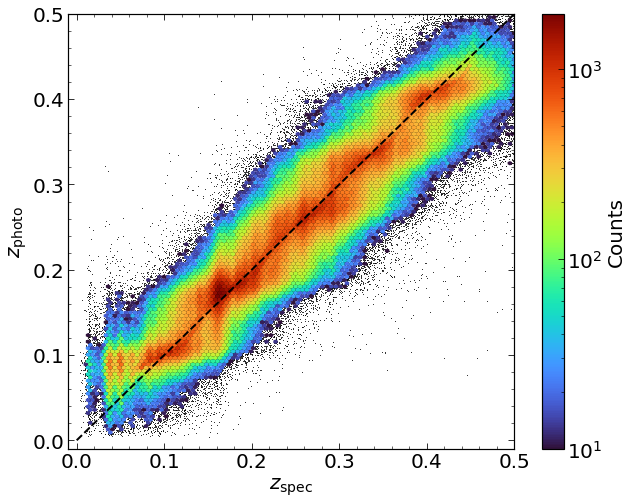

In [72]:
# Plotting the predicted z against the spec-z

sample=df[(df['Zpeak']>0.004) & (df['Zpeak']<0.5)]
plt.scatter(sample['Z'],
            sample['Zpeak'],
            s=1,c='k',label='Galaxies',linewidth=0)
im=plt.hexbin(sample['Z'],sample['Zpeak'],gridsize=(100,round(100*2/3)),
              cmap='turbo',extent=(-0.01,0.5,-0.01,0.5),mincnt=10,linewidths=0,norm=matplotlib.colors.LogNorm())

plt.plot([0,0.5],[0,0.5],c='k',linestyle='dashed',linewidth=2)
plt.xlabel(r'$z_\mathrm{spec}$',fontsize=20)
plt.ylabel(r'$z_\mathrm{photo}$',fontsize=20)
plt.xlim(-0.01,0.5)
plt.ylim(-0.01,0.5)

cbar=plt.colorbar().set_label(label='Counts')
im.figure.axes[1].tick_params(labelsize=20)

plt.savefig('plots/z_photo_z_spec.jpg',bbox_inches='tight',dpi=200)

plt.show()

In [35]:
# Median deviation from spec-z
np.median((sample['Zpeak']-sample['Z'])/(1+sample['Z']))

-0.0004969128998558519

In [36]:
# Median absolute deviation from spec-z
np.median(abs(sample['Zpeak']-sample['Z'])/(1+sample['Z']))

0.01709007028564998

In [37]:
# SMAD for photo-z mode
1.4826*np.median(abs(((sample['Zpeak']-sample['Z'])/(1+sample['Z'])) - 
                     np.median(((sample['Zpeak']-sample['Z'])/(1+sample['Z'])))))

0.025322236360939006

In [38]:
# SMAD for photo-z mean
1.4826*np.median(abs(((sample['Znorm']-sample['Z'])/(1+sample['Z'])) - 
                     np.median(((sample['Znorm']-sample['Z'])/(1+sample['Z'])))))

0.024904472668042615

In [74]:
# Initialising an r<19.8 magnitude limited subset
df19=df[df['Rpetro']<19.8].copy()

In [75]:
# Initialising the groups (haloes) from the r<19.8 subset.
# Worth noting that galaxy_id==0 in FS2 means it is the halo centre
haloes=df19[df19['galaxy_id']==0]['HaloID'].values

In [76]:
H0 = cosmo.H(0)
h=H0.value/100

In [77]:
# Creating the halo catalogue with properties
dfHalo=pd.DataFrame(index=df.groupby('HaloID').size().index)

dfHalo['N']=df19.groupby('HaloID').size()
dfHalo['Mass']=10**df.groupby('HaloID').mean()['lm_halo']
dfHalo=dfHalo.loc[haloes]
dfHalo['RA']=df19[df19['galaxy_id']==0]['RA'].values
dfHalo['Dec']=df19[df19['galaxy_id']==0]['Dec'].values
dfHalo['Z']=df19[df19['galaxy_id']==0]['Z'].values
dfHalo['Centre']=df19[df19['galaxy_id']==0].index
dfHalo['Distance']=(cosmo.comoving_distance(dfHalo['Z']).value)*1e6*h
dfHalo=dfHalo[dfHalo['N']>1].copy()

#N21 is the number of r<21 mmembers of each halo
dfHalo['N21']=df.groupby('HaloID').size().loc[dfHalo.index]

In [82]:
# Defining r_200 and v_200 
def H(z):
    return cosmo.H(z).value

dfHalo['H']=dfHalo['Z'].apply(H)

from astropy.constants import G
GMpc = G.to(u.M_sun**-1 * u.km**2 * u.s**-2 * u.Mpc).value
Gpc = G.to(u.M_sun**-1 * u.km**2 * u.s**-2 * u.pc).value

delta=200

dfHalo['r_200']=(((2*GMpc*dfHalo['Mass'])/(delta * dfHalo['H']**2))**(1/3))*1e6

dfHalo['v_200']=10*dfHalo['H']*dfHalo['r_200']/1e3

dfHalo['Ang_link']=dfHalo['r_200']/dfHalo['Distance']

In [83]:
# Recessional velocities of galaxies and groups (we do supplementation in velocity, not redshift space)
from astropy.constants import c
C=c.value

dfHalo['V'] = (cosmo.H0*cosmo.comoving_distance(np.array(dfHalo['Z']))).value/(1+dfHalo['Z'])*1e3

df['V']=(cosmo.H0*cosmo.comoving_distance(np.array(df['Zpeak']))).value/(1+df['Zpeak'])*1e3

In [84]:
# Creating a dataframe of just 19.8 < r < 21 outside the magnitude limit of spectro
dfphoto=df.drop(df19.index)

In [85]:
# Creating KDtrees of groups and galaxies in angular and velocity space
import math
from sklearn.neighbors import KDTree

dfHalo['DecRad'] = (dfHalo['Dec']).apply(math.radians)
dfHalo['RARad'] = (dfHalo['RA']).apply(math.radians)
dfphoto['DecRad'] = (dfphoto['Dec']).apply(math.radians)
dfphoto['RARad'] = (dfphoto['RA']).apply(math.radians)

ANG_halo=np.array(list(zip(dfHalo['RARad'],dfHalo['DecRad'])))
ANGTree_halo=KDTree(ANG_halo, leaf_size=2) 

ANG_gal=np.array(list(zip(dfphoto['RARad'],dfphoto['DecRad'])))
ANGTree_gal=KDTree(ANG_gal, leaf_size=2) 

VEL_halo=np.array(list(zip(dfHalo['V'])))
VELTree_halo=KDTree(VEL_halo, leaf_size=2) 

VEL_gal=np.array(list(zip(dfphoto['V'])))
VELTree_gal=KDTree(VEL_gal, leaf_size=2) 

In [94]:
dfHalo['raw_index']=range(len(dfHalo))

In [115]:
# Using KDtrees to find all photometric galaxies within 3 R_200 and 40 V_200 of each halo
# This comes in the form of a dictionary called groups

groups={}

for halo in tqdm(dfHalo.index):
    
    ANGind = ANGTree_gal.query_radius(ANG_halo[[int(dfHalo.loc[halo]['raw_index'])]], r=3*dfHalo['Ang_link'][halo])
    
    if len(ANGind[0])>0:
        VELtree = KDTree(VEL_gal[ANGind[0]], leaf_size=2)
        ind = VELtree.query_radius(VEL_halo[[int(dfHalo.loc[halo]['raw_index'])]], r=40*dfHalo['v_200'][halo])
        groups[halo]=(dfphoto.iloc[ANGind[0]]).iloc[ind[0]].index.values
    else:
        groups[halo]=[]

  0%|          | 0/37279 [00:00<?, ?it/s]

In [118]:
# Defining angular separation functio
def angsep(lon1, lat1, lon2, lat2):

    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)

In [119]:
df19['RARad']=df19['RA']*(np.pi/180)
df19['DecRad']=df19['Dec']*(np.pi/180)

In [120]:
# Next we'll be making a dataframe called probdf
# The purpose of this dataframe is to keep track of all halo-galaxy associations

In [121]:
# This loop goes through the groups dictionary we just made
# It then makes a list of the halo in the association, the galaxy, their velocity and radial difference, and whether the match is true or not

halos=[]
gals=[]
vel_diff=[]
rad_diff=[]
is_match=[]

for halo in tqdm((groups)):
    for gal in groups[halo]:
        halos.append(halo)
        gals.append(gal)
        vel_diff.append(abs(dfHalo['V'][halo] - dfphoto['V'][gal])/dfHalo['v_200'][halo])
        rad_diff.append((angsep(df19.loc[dfHalo.loc[halo]['Centre']]['RARad'],df19.loc[dfHalo.loc[halo]['Centre']]['DecRad'],
                                dfphoto.loc[gal]['RARad'],dfphoto.loc[gal]['DecRad']))/dfHalo['Ang_link'][halo])
        if df.loc[gal]['HaloID']==halo:
            is_match.append(True)
        else:
            is_match.append(False)

  0%|          | 0/37279 [00:00<?, ?it/s]

In [122]:
# Adding the columns to the probdf dataframe

probdf=pd.DataFrame()
probdf['halo']=halos
probdf['gal']=gals
probdf['vel_diff']=vel_diff
probdf['rad_diff']=rad_diff
probdf['match']=is_match

In [125]:
# Here we make our halo profile
# This is done by measuring the fraction of true galaxy-halo associations at each r/r_200 and v/v_200

n=20

r_range=np.linspace(0,3,n+1)
vel_range=np.linspace(0,40,n+1)
r_centres=(r_range[:-1] + r_range[1:]) / 2
vel_centres=(vel_range[:-1] + vel_range[1:]) / 2

r=[]
vel=[]
fracs=[]


frac_arr=np.zeros((n,n))

for i in tqdm(range(len(r_centres))):
    for j in range(len(vel_centres)):
        probdf_lim=probdf[(probdf['rad_diff'] > r_range[i]) & (probdf['rad_diff'] < r_range[i+1]) & (probdf['vel_diff'] > vel_range[j]) & (probdf['vel_diff'] < vel_range[j+1])]
        if len(probdf_lim)>0:          
            frac=(len(probdf_lim[probdf_lim['match']==True])/len(probdf_lim))
            frac_arr[j,i]=frac
            r.append(r_centres[i])
            vel.append(vel_centres[j])
            fracs.append(frac)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
#np.save('fracs',fracs)
#np.save('r',r)
#np.save('vel',vel)

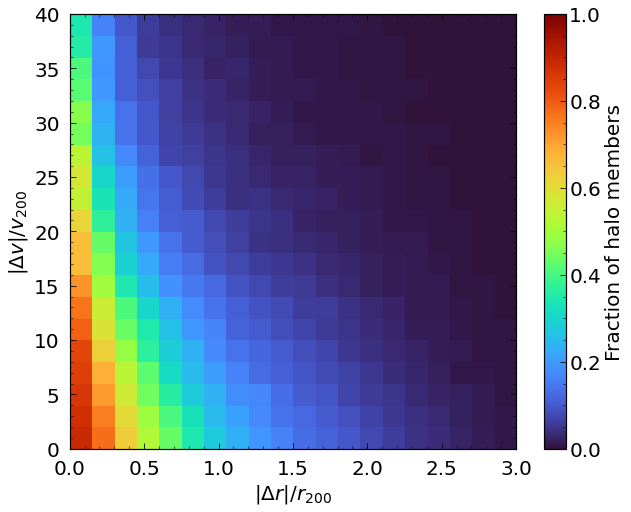

In [127]:
# Visualsing the halo profile

from matplotlib.colors import LogNorm

im=plt.imshow(frac_arr,extent=[min(r_range),max(r_range),max(vel_range),min(vel_range)],
           aspect='auto',cmap='turbo')
cbar=plt.colorbar().set_label(label='Fraction of halo members')
im.figure.axes[1].tick_params()
plt.gca().invert_yaxis()


plt.clim(0,1)
plt.axvline(0,c='k',linewidth=1,linestyle='dashed')
plt.xlabel('$ | \Delta r | /r_{200}$')
plt.ylabel('$ | \Delta v | / v_{200}}$')
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=10)

#plt.savefig('v_200_r_200.jpg', bbox_inches='tight', dpi=200)

plt.show()

In [131]:
# Now we'll use scipy to interpolate between the 20 x 20 grid to make a spline
import scipy as sp
import scipy.interpolate

spline = sp.interpolate.Rbf(r,vel,fracs,smooth=0.05)

r_grid=np.linspace(0,3,100)
vel_grid=np.linspace(0,40,100)
r_mesh, vel_mesh = np.meshgrid(r_grid, vel_grid, indexing='xy')
Z = np.zeros((np.array(r).size, np.array(vel).size))

Z = spline(r_mesh,vel_mesh)


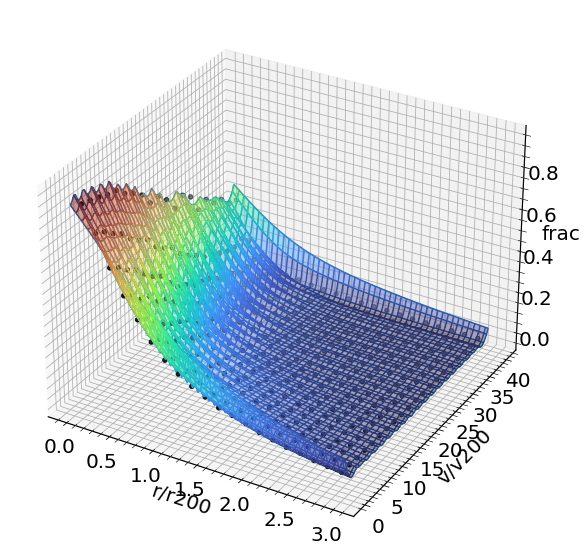

In [133]:
#Plotting the spline and the 20 x 20 grid previously in 3D

from mpl_toolkits.mplot3d import axes3d

from matplotlib import cm
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_wireframe(r_mesh, vel_mesh, Z.reshape(100,100))
ax.plot_surface(r_mesh, vel_mesh, Z.reshape(100,100),alpha=0.4,
                cmap=cm.turbo,linewidth=0, antialiased=False)
ax.scatter3D(r,vel,fracs,c='k')
ax.set_xlabel('r/r200')
ax.set_ylabel('v/v200')
ax.set_zlabel('frac')

#plt.savefig('spline.jpg',overwrite=True)

plt.show()

In [134]:
df['RARad']=(np.pi/180)*df['RA']
df['DecRad']=(np.pi/180)*df['Dec']

In [155]:
# Here's where we find the probability of each galaxy-halo association
# We do this by iterating through probdf
spline_prob=[]
spline_sharp_prob=[]
vel_array=(cosmo.H0*cosmo.comoving_distance(z_grid)).value/(1+z_grid)*1e3
for ix in tqdm(probdf.index):
    halo=probdf['halo'][ix]
    gal=probdf['gal'][ix]
    index=df['raw_index'][gal]
    
    # Extracting angular difference between halo and galaxy
    ang_diff=probdf.loc[ix]['rad_diff']
    
    # Creating an array of deviation from halo velocity 
    vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]
    
    # Creating the PDF of halo velocity given the ang_diff and the profile created earlier
    spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<40])),
                        vel_diff_array[vel_diff_array<40])
    
    #Multplying the PDF of halo velocity with cdes, the galaxy p(z) and then normalising
    spline_prob.append(sum(spline_array*cdes[index][vel_diff_array[:,0]<40]/sum(cdes[index])))
    
    #Same for post processed p(z)
    spline_sharp_prob.append(sum(spline_array*cdes_sharp[index][vel_diff_array[:,0]<40]/sum(cdes_sharp[index])))

  0%|          | 0/1856759 [00:00<?, ?it/s]

In [156]:
# Adding probabilities to porobdf
probdf['spline_prob']=spline_prob
probdf['sharp_spline_prob']=spline_sharp_prob

In [157]:
#Setting probabilities that are less than 0 to 0

probdf['sharp_spline_prob']=probdf['sharp_spline_prob'].clip(lower=0)
probdf['spline_prob']=probdf['spline_prob'].clip(lower=0)

/its/home/tc339/.conda/envs/env/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


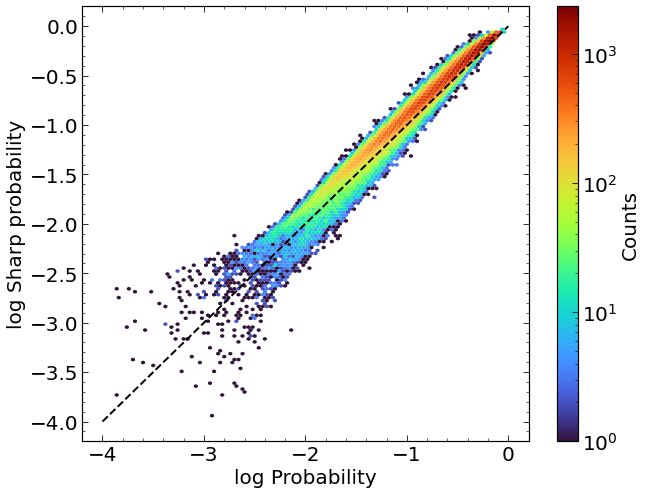

In [164]:
# Plot comparing the processed probabilities with the unprocessed probabilities
im=plt.hexbin(np.log10(probdf[probdf['match']==True]['spline_prob']),
              np.log10(probdf[probdf['match']==True]['sharp_spline_prob']),
              gridsize=(100,round(100*2/3)),cmap='turbo',extent=(-4,0,-4,0),
              mincnt=1,linewidths=0,norm=matplotlib.colors.LogNorm())
plt.plot([-4,0],[-4,0],c='k',linestyle='dashed',linewidth=2)

cbar=plt.colorbar().set_label(label='Counts',fontsize=20)
im.figure.axes[1].tick_params(labelsize=20)
plt.xlabel('log Probability')
plt.ylabel('log Sharp probability')
plt.show()

plt.show()

In [185]:
# These two cells are just for plotting an example galaxy-halo association
# In this case, we're looking at a random association from probdf with a >0.9 probability

ix=random.choice(probdf[probdf['sharp_spline_prob']>0.9].index)
halo=probdf['halo'][ix]
gal=probdf['gal'][ix]
index=dfphoto['raw_index'][gal]
ang_diff=angsep(df19.loc[dfHalo.loc[halo]['Centre']]['RARad'],df19.loc[dfHalo.loc[halo]['Centre']]['DecRad'],dfphoto.loc[gal]['RARad'],dfphoto.loc[gal]['DecRad'])/dfHalo['Ang_link'][halo]
vel_array=(cosmo.H0*cosmo.comoving_distance(z_grid)).value/(1+z_grid)*1e3
vel_diff_array=abs(dfHalo['V'][halo]-vel_array)/dfHalo['v_200'][halo]
spline_array=spline(ang_diff*np.ones(len(vel_diff_array[vel_diff_array<15])),vel_diff_array[vel_diff_array<15])
sharp_prob=probdf['sharp_spline_prob'][ix]
prob=probdf['spline_prob'][ix]

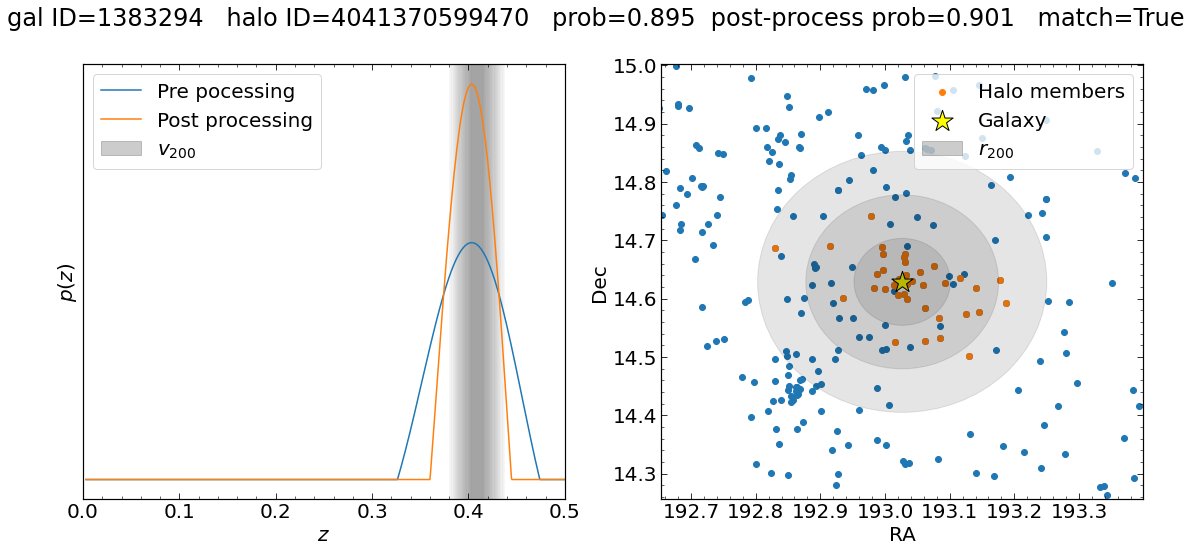

In [201]:
fig, ax = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(19,8))
fig.subplots_adjust( wspace=0.2)
axs=ax.ravel()

from astropy.constants import c
v_grid=np.linspace(1,5,20)
r_grid=np.linspace(1,3,3)

for v in v_grid:
    axs[0].axvspan(dfHalo['Z'][halo]-v*(dfHalo['v_200'][halo]*(1+dfHalo['Z'][halo])/c.to(u.m/u.s).value),
                dfHalo['Z'][halo]+v*(dfHalo['v_200'][halo]*(1+dfHalo['Z'][halo])/c.to(u.m/u.s).value),
                alpha=0.02, color='black')
axs[0].plot(z_grid,cdes[index]/np.trapz(cdes[index]),label='Pre pocessing')
axs[0].plot(z_grid,cdes_sharp[index]/np.trapz(cdes_sharp[index]),label='Post processing')

axs[0].axvspan(-2,-1,alpha=0.2, color='black',label='$v_{200}$')
            

axs[0].set_xlabel('$z$')
axs[0].set_ylabel('$p(z)$')
axs[0].set_yticks([])
axs[0].set_xlim(0,0.5)
#plt.title('prob='+str(round(prob,3))+ '  post-process prob=' +str(round(sharp_prob,3))+'   match='+str(probdf['match'][ix]))
axs[0].legend(frameon=True)

sample=df[(df['Z']>dfHalo['Z'][halo]-3*(dfHalo['v_200'][halo]*(1+dfHalo['Z'][halo])/c.to(u.m/u.s).value)) &
          (df['Z']<dfHalo['Z'][halo]+3*(dfHalo['v_200'][halo]*(1+dfHalo['Z'][halo])/c.to(u.m/u.s).value))]


axs[1].scatter(sample['RA'],
            sample['Dec'])
axs[1].scatter(df[df['HaloID']==halo]['RA'],df[df['HaloID']==halo]['Dec'],label='Halo members')

axs[1].scatter(dfphoto.loc[gal]['RA'],dfphoto.loc[gal]['Dec'],c='yellow',marker='*',edgecolors='black',s=500,
              label='Galaxy')


for r in r_grid:
    circle=plt.Circle((dfHalo['RA'][halo],dfHalo['Dec'][halo]), 
                       r*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo], 
                       color='black',alpha=0.1)
    axs[1].add_patch(circle)

circle=plt.Circle((-100,-100),r*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo], 
                       color='black',alpha=0.2,label='$r_{200}$')
axs[1].add_patch(circle)


axs[1].set_xlim(dfHalo['RA'][halo]-5*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo],
        dfHalo['RA'][halo]+5*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo])
axs[1].set_ylim(dfHalo['Dec'][halo]-5*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo],
        dfHalo['Dec'][halo]+5*(180/np.pi)*dfHalo['r_200'][halo]/dfHalo['Distance'][halo])
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
axs[1].legend(frameon=True)
plt.suptitle('gal ID='+str(gal)+'   halo ID='+str(halo)+'   prob='+str(round(prob,3))+ '  post-process prob=' +str(round(sharp_prob,3))+
             '   match='+str(probdf['match'][ix]))

plt.savefig('plots/prob_example.jpg',bbox_inches='tight',dpi=200)

plt.show()


In [188]:
# Median probabilities of TRUE assocations
print(np.median(probdf[probdf['match']==True]['spline_prob']))
print(np.median(probdf[probdf['match']==True]['sharp_spline_prob']))

0.21555285203096086
0.26144721314951713


In [190]:
# Median probabilities of FALSE assocations
print(np.median(probdf[probdf['match']==False]['spline_prob']))
print(np.median(probdf[probdf['match']==False]['sharp_spline_prob']))

0.0174685529478183
0.018543547148370636


In [198]:
# Calculating the F1 score as a function of probability
probs_arr=np.logspace(-3,0,100)

f1_arr=[]
for i in tqdm(probs_arr):
    TP=len(probdf[(probdf['sharp_spline_prob']>i) & (probdf['match']==True)])
    FP=len(probdf[(probdf['sharp_spline_prob']>i) & (probdf['match']==False)])
    FN=len(probdf[(probdf['sharp_spline_prob']<i) & (probdf['match']==True)])
    f1_arr.append(2*TP/(2*TP + FN + FP))

  0%|          | 0/100 [00:00<?, ?it/s]

In [199]:
# threshold is the probability at which the F1 score is maximised
threshold=probs_arr[f1_arr.index(max(f1_arr))]
print(threshold)

0.24770763559917114


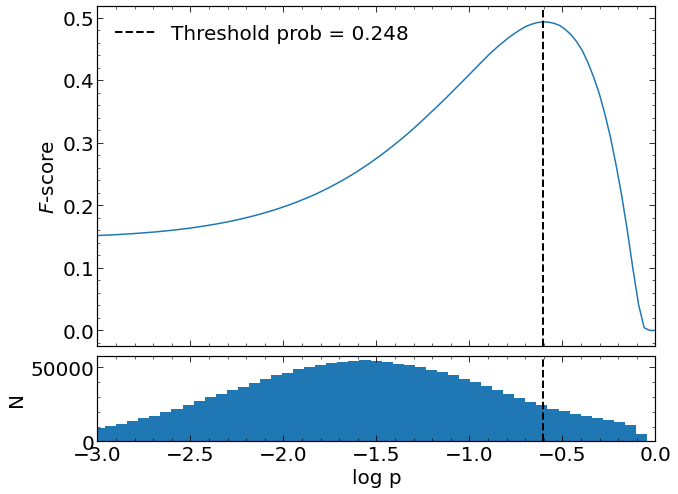

In [205]:
# Plotting the F1 score as a function of probability
fig, axs = plt.subplots(2,1, facecolor='w', edgecolor='k',gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace = 0.05, wspace=0)

axs[0].plot(np.log10(probs_arr),f1_arr)
axs[0].xaxis.set_ticklabels([])
axs[0].set_ylabel(r'$F$'+'-score')
axs[0].set_xlim(-3,0)
axs[0].axvline(np.log10(threshold),c='k',linewidth=2,linestyle='dashed',label='Threshold prob = '+str(round(threshold,3)))
axs[0].legend(frameon=False)

axs[1].hist(np.log10(probdf[probdf['sharp_spline_prob']>1e-6]['sharp_spline_prob']),bins=100)
axs[1].axvline(np.log10(threshold),c='k',linewidth=2,linestyle='dashed')
axs[1].set_xlim(-3,0)
axs[1].set_xlabel('log p')
axs[1].set_ylabel('N')

plt.savefig('plots/F1_prob.jpg',bbox_inches='tight',dpi=200)

plt.show()

### Now we move on to the photometric redshift refinment

In [210]:
# Creating a z_tag column for photometric galaxies full of NaNs initially
dfphoto['Z_tag']=np.NAN

In [213]:
# Iterating through probdf, and appending z_tag if the probability is greater than the threshold
# probdf is sorted by probability here, meaning that with multiple associations, the higher prob takes precedence
for i in tqdm(probdf.sort_values('sharp_spline_prob').index):
    if probdf.loc[i]['sharp_spline_prob']>threshold:
        gal_id = probdf.loc[i]['gal']
        halo_id = probdf.loc[i]['halo']
        halo_z = dfHalo.loc[halo_id]['Z']
        dfphoto.loc[gal_id,'Z_tag']=halo_z    

  0%|          | 0/1856759 [00:00<?, ?it/s]

In [214]:
sample=dfphoto[(dfphoto['Zpeak']>0.004) & (dfphoto['Zpeak']<0.5) & (dfphoto['Zpeak']<0.5) & (dfphoto['Z_tag']>0)]

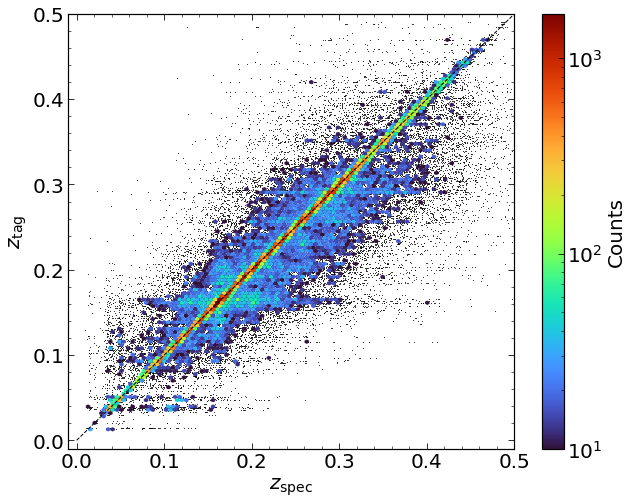

In [215]:
# Plotting the spec-z versus the new tagged-z
plt.scatter(sample['Z'],
            sample['Z_tag'],
            s=1,c='k',linewidth=0)
im=plt.hexbin(sample['Z'],sample['Z_tag'],gridsize=(100,round(100*2/3)),
              cmap='turbo',extent=(-0.01,0.5,-0.01,0.5),mincnt=10,linewidths=0,norm=matplotlib.colors.LogNorm())

plt.plot([0,0.5],[0,0.5],c='k',linestyle='dashed',linewidth=1)
plt.xlabel(r'$z_\mathrm{spec}$',fontsize=20)
plt.ylabel(r'$z_\mathrm{tag}$',fontsize=20)
plt.xlim(-0.01,0.5)
plt.ylim(-0.01,0.5)

cbar=plt.colorbar().set_label(label='Counts')
im.figure.axes[1].tick_params(labelsize=20)

plt.savefig('plots/z_tag_z_spec.jpg',bbox_inches='tight',dpi=200)

plt.show()

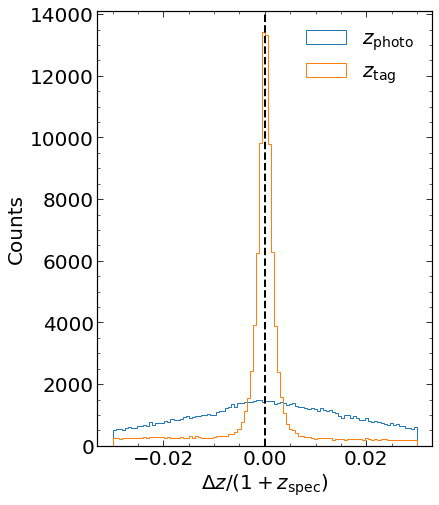

In [216]:
# Comparing the initial photometric redshifts with the new z tag
plt.figure(figsize=(6,8))
plt.hist((sample['Zpeak']-sample['Z'])/(1+sample['Z']),
         bins=np.linspace(-0.03,0.03,101),histtype='step',label='$z_\mathrm{photo}$')
plt.hist((sample['Z_tag']-sample['Z'])/(1+sample['Z']),
         bins=np.linspace(-0.03,0.03,101),histtype='step',label='$z_\mathrm{tag}$')
plt.axvline(0,c='k',linestyle='dashed',linewidth=2)
plt.xlabel('$\Delta z / (1+z_\mathrm{spec})$')
plt.ylabel('Counts')
plt.legend(frameon=False)

plt.savefig('plots/z_tag_z_photo.jpg',bbox_inches='tight',dpi=200)

plt.show()

In [217]:
# Median absolute deviation of z-tag from z-spec
np.median(abs(sample['Z_tag']-sample['Z'])/(1+sample['Z']))

0.0020901980956164377

In [218]:
# Median absolute deviation of z-photo from z-spec
np.median(abs(sample['Zpeak']-sample['Z'])/(1+sample['Z']))

0.015531760606257

In [219]:
# SMAD from z-tag
1.4826*np.median(abs(((sample['Z_tag']-sample['Z'])/(1+sample['Z'])) - 
                     np.median(((sample['Z_tag']-sample['Z'])/(1+sample['Z'])))))

0.003116780775201601

In [220]:
# SMAD from z-photo
1.4826*np.median(abs(((sample['Zpeak']-sample['Z'])/(1+sample['Z'])) - 
                     np.median(((sample['Zpeak']-sample['Z'])/(1+sample['Z'])))))

0.022953894953798085

### Halo property refinements

In [221]:
dfHalo['N_new'], dfHalo['N_new_sharp'], dfHalo['N_new_threshold'], dfHalo['N_thresh_and_prob']=dfHalo['N'], dfHalo['N'], dfHalo['N'], dfHalo['N']

In [ ]:
for i in tqdm(probdf.index):
    halo=probdf['halo'][i]
    dfHalo['N_new'].loc[halo]+=probdf['spline_prob'][i]
    dfHalo['N_new_sharp'].loc[halo]+=probdf['sharp_spline_prob'][i]
    if probdf['sharp_spline_prob'][i] >threshold:
        dfHalo['N_new_threshold'].loc[halo]+=1
        dfHalo['N_thresh_and_prob'].loc[halo]+=probdf['sharp_spline_prob'][i]

  0%|          | 0/1856759 [00:00<?, ?it/s]

In [ ]:
dfHalo['N21_scatter']=dfHalo['N21']
dfHalo['N_sharp_scatter']=dfHalo['N_new_sharp']
dfHalo['N_threshold_scatter']=dfHalo['N_new_threshold']
dfHalo['N_scatter']=dfHalo['N']

In [ ]:
for i in tqdm(dfHalo.index):
    sig=0.4
    dfHalo.loc[i,'N21_scatter'] = dfHalo.loc[i,'N21'] + np.random.normal(0,sig)
    dfHalo.loc[i,'N_sharp_scatter'] = dfHalo.loc[i,'N_new_sharp'] + np.random.normal(0,sig)
    dfHalo.loc[i,'N_threshold_scatter'] = dfHalo.loc[i,'N_new_threshold'] + np.random.normal(0,sig)
    dfHalo.loc[i,'N_scatter'] = dfHalo.loc[i,'N'] + np.random.normal(0,sig)

In [ ]:
perc=95
n_bins=np.logspace(0.2,3,20)
n_centres=(n_bins[:-1] + n_bins[1:]) / 2
n_19_err_low=[]
n_19_err_high=[]
n_prob_err_low=[]
n_prob_err_high=[]
for i in tqdm(range(len(n_bins[:-1]))):
    n_low=n_bins[i]
    n_high=n_bins[i+1]
    sample=dfHalo[(dfHalo['N21']>n_low) & (dfHalo['N21']<n_high)]
    n_19_err_low.append(np.percentile(sample['N'],100-perc))
    n_19_err_high.append(np.percentile(sample['N'],perc))
    n_prob_err_low.append(np.percentile(sample['N_new_sharp'],100-perc))
    n_prob_err_high.append(np.percentile(sample['N_new_sharp'],perc))

In [ ]:
plt.scatter(dfHalo['N21'],dfHalo['N'],linewidth=0,s=5,label=r'$\mathrm{N_{r<19.8}}$',c='C0')
plt.scatter(dfHalo['N21'],dfHalo['N_new_sharp'],linewidth=0,s=5,label=r'$\mathrm{N_{supplementation}}$',c='orange')
#plt.scatter(dfHalo['N21_scatter'],dfHalo['N_threshold_scatter'],s=5,label=r'$\mathrm{N_{threshold}}$')

plt.fill_between(n_centres, n_prob_err_low, n_prob_err_high,alpha=0.3,color='orange')
plt.fill_between(n_centres, n_19_err_low, n_19_err_high,alpha=0.3,color='C0')
plt.plot(n_centres,n_prob_err_high,c='k',linewidth=0.5)
plt.plot(n_centres,n_prob_err_low,c='k',linewidth=0.5)
plt.plot(n_centres,n_19_err_high,c='k',linewidth=0.5)
plt.plot(n_centres,n_19_err_low,c='k',linewidth=0.5)


plt.plot([1,1000],[1,1000],c='k',linestyle='dashed')
plt.xlim(1.5,1000)
plt.ylim(1.5,1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{N_{r<21}}$')
plt.ylabel(r'$\mathrm{N_{recovered}}$')
lgnd=plt.legend(frameon=False)
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.savefig('halo_n.jpg',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
sample=dfHalo[dfHalo['N']>4]

In [ ]:
np.mean(sample['N']/sample['N21'])

In [ ]:
np.mean(sample['N_new_sharp']/sample['N21'])

In [ ]:
np.mean(sample['N_new_threshold']/sample['N21'])

In [ ]:
np.median(abs(sample['N_new_sharp']-sample['N21'])/sample['N21'])

In [ ]:
true_frac=[]
thresh_frac=[]
for halo in tqdm(dfHalo.index):
    if sum(probdf[probdf['halo']==halo]['sharp_spline_prob'])>0:
        true_frac.append(sum(probdf[(probdf['halo']==halo) & (probdf['match']==True)]['sharp_spline_prob'])/(
            sum(probdf[(probdf['halo']==halo) & (probdf['match']==True)]['sharp_spline_prob']) + 
            sum(probdf[(probdf['halo']==halo) & (probdf['match']==False)]['sharp_spline_prob'])))
    else:
        true_frac.append(np.NAN)
        
    if dfHalo['N_new_threshold'][halo]>dfHalo['N'][halo]:
        thresh_frac.append(len(probdf[(probdf['halo']==halo) & (probdf['sharp_spline_prob']>threshold) & (probdf['match']==True)])/(
            len(probdf[(probdf['halo']==halo) & (probdf['sharp_spline_prob']>threshold) & (probdf['match']==True)]) +
            len(probdf[(probdf['halo']==halo) & (probdf['sharp_spline_prob']>threshold) & (probdf['match']==False)])))
    else:
        thresh_frac.append(np.NAN)
    

In [ ]:
dfHalo['true_frac']=true_frac
dfHalo['threshold_frac']=thresh_frac

In [ ]:
plt.hist(dfHalo['true_frac'],bins=100)
plt.show()

In [ ]:
plt.hist(dfHalo['threshold_frac'],bins=100)
plt.show()

In [ ]:
plt.scatter(dfHalo['N'],dfHalo['true_frac'],s=1)
plt.xscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
np.mean(dfHalo[dfHalo['N']>4]['N_new_threshold']/dfHalo[dfHalo['N']>4]['N'])

In [ ]:
print(sum(probdf[probdf['match']==True]['sharp_spline_prob']))
print(sum(probdf[probdf['match']==False]['sharp_spline_prob']))

In [ ]:
print(len(probdf[(probdf['match']==True) & (probdf['sharp_spline_prob']>threshold)]))
print(len(probdf[(probdf['match']==False) & (probdf['sharp_spline_prob']>threshold)]))

In [ ]:
print(sum(probdf[(probdf['match']==True) & (probdf['sharp_spline_prob']>threshold)]['sharp_spline_prob']))
print(sum(probdf[(probdf['match']==False) & (probdf['sharp_spline_prob']>threshold)]['sharp_spline_prob']))

In [ ]:
from astropy.constants import c
C=c.value

df['v'] = df['Z'] * C/1000

In [ ]:
groupdictvel={}
for i in tqdm(dfHalo.index):
    groupdictvel[i] = []
    for j in list(df19[df19['HaloID']==i].index):
        groupdictvel[i].append(df['v'][j])       

In [ ]:
for i in groupdictvel:
    groupdictvel[i] = sorted(groupdictvel[i])
    
s = []
for i in tqdm(dfHalo.index):
    N = len(groupdictvel[i])
    fact = np.sqrt(np.pi) / (N * (N - 1))
    wgsum=0
    for j in range(1,N):
        w = (j * (N-j))
        g = (groupdictvel[i][j] - groupdictvel[i][j-1])/(1+dfHalo['Z'][i])
        wgsum += w * g
    sgap =  fact * wgsum
    s.append(np.sqrt((N/(N-1)) * sgap**2 - (np.sqrt(N*(30**2))/np.sqrt(N))**2))
    #s.append(sgap/1e3)
dfHalo['VelDisp'] = np.array(s)


for i in groupdictvel:
    groupdictvel[i] = sorted(groupdictvel[i])
    



In [ ]:
np.median(dfHalo[(dfHalo['VelDisp']>0) & (dfHalo['N']>4)]['VelDisp'])

In [ ]:
RecCentres=[]
for group in dfHalo.index:
    mags={}
    for galaxy in list(df19[df19['HaloID']==group].index):
        mags[galaxy] = (df['abs_mag_r01'][galaxy])
    RecCentres.append(list(mags.keys())[list(mags.values()).index(min(mags.values()))])
    
dfHalo['Centre'] = RecCentres

In [ ]:
def angsep(lon1, lat1, lon2, lat2):

    

    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)

In [ ]:
df['RARad']=df['RA']*(np.pi/180)
df['DecRad']=df['Dec']*(np.pi/180)

In [ ]:
df['CoDistance']=cosmo.comoving_distance(np.array(df['Z'])).value *1e6 * h

In [ ]:
def radiuscalc(percentile):
    Radius=[]
    for group in tqdm(dfHalo.index):
        centre = dfHalo['Centre'][group]
        distances = []
        for galaxy in list(df19[df19['HaloID']==group].index):
            distances.append(df['CoDistance'][centre]*(angsep(df.loc[centre]['RARad'],df.loc[centre]['DecRad'],
                                                              df.loc[galaxy]['RARad'],df.loc[galaxy]['DecRad'])))
        Radius.append(np.percentile(distances,percentile,interpolation='linear'))
    return Radius

In [ ]:
dfHalo['Radius50'] = radiuscalc(50)

In [ ]:
np.median(dfHalo[(dfHalo['VelDisp']>0) & (dfHalo['N']>4)]['Radius50'])/1e6

In [ ]:
def DynMass(A,VelDisp,Radius):
    return (A/(G)) * (VelDisp)**2 * ((Radius/1e6)/h**-1)

In [ ]:
from astropy.constants import G
G = G.to(u.M_sun**-1 * u.km**2 * u.s**-2 * u.Mpc).value

In [ ]:
dfHalo['DynMassRaw'] = DynMass(1,dfHalo['VelDisp'],dfHalo['Radius50'])

In [ ]:
import emcee
import corner

In [ ]:
sample=dfHalo[dfHalo['N']>1]

In [ ]:
def model(theta,mass=sample['DynMassRaw'], n=sample['N'], z=sample['Z']):
    A_c, A_n, A_z = theta
    model = mass * (A_c + (A_n/np.sqrt(n)) + (A_z/np.sqrt(z)))
    return model

In [ ]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((np.log10(y) - np.log10(model(theta, x)))) ** 2)

In [ ]:
def lnprior(theta):
    A_c, A_n, A_z = theta
    if -5 < A_c < 5 and 0 < A_n < 25 and -2 < A_z < 3:
        return 0.0
    return -np.inf

In [ ]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [ ]:
M_err = np.log10(0.01*np.mean(sample['Mass']))
data = (sample['DynMassRaw'], sample['Mass'] ,M_err)
nwalkers = 240
niter = 1000
initial = np.array([0,20,2])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [ ]:
%%time
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

In [ ]:
# Plot the samples
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ['$A_c$', '$A_\mathrm{N}$', '$A_z$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.get_chain()))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
samples = sampler.flatchain
theta=samples[np.argmax(sampler.flatlnprobability)]

In [ ]:
samples

In [ ]:
data_kwargs={}
data_kwargs['marker']='.'
data_kwargs['alpha']=1
data_kwargs['markeredgewidth']=0
data_kwargs['ms']=1

contourf_kwargs={}
#contourf_kwargs['levels']=(0.68,0.95)
#contourf_kwargs['colors']=['red','blue']
#contourf_kwargs['alpha']=0.5
#contourf_kwargs['vmin']=0.5
#contourf_kwargs['cmap']='viridis'
#contourf_kwargs['alpha']=0.5


contour_kwargs={}
contour_kwargs['linewidths']=1


In [ ]:


labels = ['$A_c$', '$A_\mathrm{N}$', '$A_z$']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,
                    smooth=2,hist_bin_factor=1,plot_density=False,
                    data_kwargs=data_kwargs)
                   #range=([-2.5,3],[5,25],[-0.5,2]),data_kwargs=data_kwargs)#,
                    #levels=(0.69,0.95), #fill_contours=True, #contourf_kwargs=contourf_kwargs,
                   #contour_kwargs=contour_kwargs)#color='red')
#plt.savefig('mass_corner_plot.jpg', bbox_inches='tight', dpi=200)

In [ ]:
theta[0]=np.median(samples[:,0])
theta[1]=np.median(samples[:,1])
theta[2]=np.median(samples[:,2])
theta

In [ ]:
def A(N,Z):
    return theta[0]+(theta[1]/np.sqrt(N))+(theta[2]/np.sqrt(Z))

dfHalo['A'] = A(dfHalo['N'],dfHalo['Z'])

dfHalo['DynMassA'] = DynMass(dfHalo['A'],dfHalo['VelDisp'],dfHalo['Radius50'])

In [ ]:
dfhalo5=dfHalo[dfHalo['N']>4].copy()

In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(16,8))
fig.subplots_adjust(hspace = 0, wspace=0.1)
axs=axs.ravel()

sample=dfHalo[(dfHalo['DynMassA']>0) & (dfHalo['N']>1)]
MAE=sum(abs(np.log10(sample['DynMassA'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['DynMassA'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['DynMassA'])-np.mean(np.log10(sample['Mass'])))**2))

axs[0].hexbin(sample['Mass'],
              sample['DynMassA'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=50,xscale='log',yscale='log')
axs[0].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[0].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[0].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[0].set_xlim(1e10,1e15)
axs[0].set_ylim(1e10,1e15)
axs[0].set_xlabel('Halo Mass [$h^{-1}\mathrm{M_\odot}$]')
axs[0].set_ylabel('Dynamical Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
axs[0].set_title('$N \geq 2$')
axs[0].set_aspect('equal', adjustable='box')
axs[0].text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=axs[0].transAxes)
axs[0].text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=axs[0].transAxes)




sample=dfHalo[(dfHalo['DynMassA']>0) & (dfHalo['N']>4)]
MAE=sum(abs(np.log10(sample['DynMassA'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['DynMassA'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['DynMassA'])-np.mean(np.log10(sample['Mass'])))**2))

axs[1].hexbin(sample['Mass'],
              sample['DynMassA'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(10,15,10,15),mincnt=1,
              linewidths=0,vmin=0,vmax=50,xscale='log',yscale='log')
axs[1].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[1].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[1].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[1].set_xlim(1e10,1e15)
axs[1].set_ylim(1e10,1e15)
axs[1].set_xlabel('Halo Mass [$h^{-1}\mathrm{M_\odot}$]')
axs[1].yaxis.set_ticklabels([])
axs[1].set_title('$N \geq 5$')
axs[1].set_aspect('equal', adjustable='box')
axs[1].text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=axs[1].transAxes)
axs[1].text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=axs[1].transAxes)



#cax = fig.add_axes([0.85,0.1,0.03,0.8]) 
im = plt.gca().get_children()[0]
fig.colorbar(im, ax=axs,pad=0.01,fraction=0.023,label='Counts')

#plt.savefig('dyn_mass_halo_mass.jpg', bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
dfHalo['LumDistance'] = cosmo.luminosity_distance(np.array(dfHalo['Z'])).value * h * 1e6

In [ ]:
a = [0.2085, 1.0226, 0.5237, 3.5902, 2.3843]
zref = 0.1
Q0 = 1.75
zp = 0.2


def kcorr(z):
    k=0
    for i in range(len(a)):
        k+= (a[i] * (z - zp)**i)

    return k - (Q0 * (z-zref))

In [ ]:
def lumconv(mag):
    return  10**(0.4 *(4.67- mag))

def massconv(lum):
    return 1e14 * h**-1 * (0.81) * (lum/(10**11.5 * h**-2))**(1.01)

In [ ]:
h

In [ ]:
df['lum']=lumconv(df['abs_mag_r01'])
df19['lum']=lumconv(df19['abs_mag_r01'])

In [ ]:
lum19_raw_arr=[]
lum21_raw_arr=[]
for halo in tqdm(dfHalo.index):
    lum21_raw_arr.append(sum(df[df['HaloID']==halo]['lum']))
    lum19_raw_arr.append(sum(df19[df19['HaloID']==halo]['lum']))

In [ ]:
dfHalo['lum19raw'] = lum19_raw_arr
dfHalo['lum21raw'] = lum21_raw_arr


In [ ]:
z_arr=np.linspace(0,0.6,1000)
distance_arr=cosmo.luminosity_distance(np.linspace(0,0.6,1000)).value*h*1e6

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mlim19(distance):
    idx=find_nearest(distance_arr,distance)
    nearest_z=z_arr[idx]
    return 19.8 - 5*np.log10(distance) + 5 #- kcorr(nearest_z)

def mlim21(distance):
    idx=find_nearest(distance_arr,distance)
    nearest_z=z_arr[idx]
    return 21 - 5*np.log10(distance) + 5 #- kcorr(nearest_z)

def sch(M,M_star,alpha,phi):
    return 0.4 * np.log(10) * phi * (10**(0.4*(M_star - M)*(alpha+1))) * np.exp(-10**(0.4*(M_star - M)))


alpha=-1.3821217577078246
M_star=-21.01915172512823
phi_star=0.0032322947599253467


from scipy import integrate

def lumest(M,M_star,alpha,phi):
    return 10**(-0.4*M) * sch(M, M_star, alpha, phi)

num = integrate.quad(lumest,-30,-14,args=(M_star,alpha,phi_star))[0]

Lumfacarr19=[]
Lumfacarr21=[]


for i in tqdm(dfHalo.index):
    Lumfacarr19.append(num / integrate.quad(lumest,-30,mlim19(dfHalo['LumDistance'][i]),args=(M_star,alpha,phi_star))[0])
    Lumfacarr21.append(num / integrate.quad(lumest,-30,mlim21(dfHalo['LumDistance'][i]),args=(M_star,alpha,phi_star))[0])

    
dfHalo['Lumfac19'] = Lumfacarr19
dfHalo['Lumfac21'] = Lumfacarr21

In [ ]:
dfHalo['lum19']=dfHalo['Lumfac19'] * dfHalo['lum19raw']

In [ ]:
lum_sup_arr=[]
for halo in tqdm(dfHalo.index):
    lum=dfHalo.loc[halo]['lum19raw']
    subset=probdf[probdf['halo']==halo]
    lum_sup_arr.append(lum + sum(subset['sharp_spline_prob'].values * 
             df.loc[subset['gal'].values]['lum'].values))

In [ ]:
dfHalo['lum_sup']=lum_sup_arr

In [ ]:
dfHalo['mass19']=massconv(dfHalo['lum19'])
dfHalo['mass_sup']=massconv(dfHalo['lum_sup']*dfHalo['Lumfac21'])

In [ ]:
font = {'size'   : 20}
plt.rc('font', **font)

In [ ]:
sample=dfHalo[dfHalo['N']>4]
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(16,8))
fig.subplots_adjust(hspace = 0, wspace=0.1)
axs=axs.ravel()

MAE=sum(abs(np.log10(sample['mass19'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['mass19'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['mass19'])-np.mean(np.log10(sample['Mass'])))**2))
axs[0].hexbin(sample['Mass'],sample['mass19'],
              gridsize=(70,round(70*2/3)),cmap='turbo',
              extent=(12,15,12,15),mincnt=1,linewidths=0,
              vmin=0,vmax=20,xscale='log',yscale='log')
axs[0].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[0].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[0].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[0].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[0].set_xlim(1e12,1e15)
axs[0].set_ylim(1e12,1e15)
axs[0].set_xlabel('Halo Mass [$h^{-1} \mathrm{M_\odot}$]')
axs[0].set_ylabel('Luminosity Mass [$h^{-1} \mathrm{M_\odot}$]')
axs[0].set_title('$r < 19.8 \ \mathrm{extrapolated}$')
axs[0].set_aspect('equal', adjustable='box')
axs[0].text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=axs[0].transAxes)
axs[0].text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=axs[0].transAxes)


MAE=sum(abs(np.log10(sample['mass_sup'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['mass_sup'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['mass_sup'])-np.mean(np.log10(sample['Mass'])))**2))
axs[1].hexbin(sample['Mass'],sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',
              extent=(12,15,12,15),mincnt=1,linewidths=0,
              vmin=0,vmax=20,xscale='log',yscale='log')
axs[1].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[1].plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
axs[1].plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
axs[1].plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
axs[1].set_xlim(1e12,1e15)
axs[1].set_ylim(1e12,1e15)
axs[1].set_xlabel('Halo Mass [$h^{-1} \mathrm{M_\odot}$]')
axs[1].yaxis.set_ticklabels([])
axs[1].set_title('$r < 21 \ \mathrm{w/ \ supplementation}$')
axs[1].set_aspect('equal', adjustable='box')
axs[1].text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=axs[1].transAxes)
axs[1].text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=axs[1].transAxes)


#cax = fig.add_axes([0.85,0.1,0.03,0.8]) 
im = plt.gca().get_children()[0]
fig.colorbar(im, ax=axs,pad=0.01,fraction=0.023,label='Counts')
fig.suptitle('$N\geq5$',fontsize=30)


#plt.savefig('lum_mass_halo_mass.jpg',bbox_inches='tight',dpi=200) 

plt.show()

In [ ]:
sample=dfHalo[(dfHalo['N']>=25) & (dfHalo['DynMassA']>0)]

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
vmax=10

In [ ]:
# Create the figure
fig = plt.figure(figsize=(18,18)) 
# Adjust the figure size as needed

# Define the GridSpec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Create the subplots with square aspect ratio
ax0 = fig.add_subplot(gs[0, 0], aspect='equal')  # Top left subplot
ax1 = fig.add_subplot(gs[0, 1], aspect='equal')  # Top right subplot
ax2 = fig.add_subplot(gs[1, 1], aspect='equal')

fig.subplots_adjust(hspace = 0.2,wspace=0.4)


MAE=sum(abs(np.log10(sample['mass19'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['mass19'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['mass19'])-np.mean(np.log10(sample['Mass'])))**2))
im=ax0.hexbin(sample['Mass'],sample['mass19'],
              gridsize=(70,round(70*2/3)),cmap='turbo',
              extent=(11,15,11,15),mincnt=1,linewidths=0,
              vmin=0,vmax=vmax,xscale='log',yscale='log')
ax0.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
ax0.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
ax0.plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
ax0.plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
ax0.set_xlim(1e11,1e15)
ax0.set_ylim(1e11,1e15)
ax0.set_xlabel('Halo Mass [$h^{-1}\mathrm{M_\odot}$]')
ax0.set_ylabel('Luminosity Mass [$h^{-1} \mathrm{M_\odot}$]')
ax0.set_aspect('equal', adjustable='box')
ax0.text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=ax0.transAxes)
ax0.text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=ax0.transAxes)
ax0.set_title('$r < 19.8$'+' extrapolated')



MAE=sum(abs(np.log10(sample['mass_sup'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['mass_sup'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['mass_sup'])-np.mean(np.log10(sample['Mass'])))**2))
im=ax1.hexbin(sample['Mass'],sample['mass_sup'],
              gridsize=(70,round(70*2/3)),cmap='turbo',
              extent=(11,15,11,15),mincnt=1,linewidths=0,
              vmin=0,vmax=vmax,xscale='log',yscale='log')
ax1.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
ax1.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
ax1.plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
ax1.plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
ax1.set_ylabel('Luminosity Mass [$h^{-1} \mathrm{M_\odot}$]')
ax1.set_xlim(1e11,1e15)
ax1.set_ylim(1e11,1e15)
ax1.set_xlabel('Halo Mass [$h^{-1}\mathrm{M_\odot}$]')
ax1.set_aspect('equal', adjustable='box')
ax1.text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=ax1.transAxes)
ax1.text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=ax1.transAxes)
ax1.set_title('$r < 21$'+' w/ supplementation')

MAE=sum(abs(np.log10(sample['DynMassA'])-np.log10(sample['Mass']))/len(sample))
r2=1-(sum((np.log10(sample['DynMassA'])-np.log10(sample['Mass']))**2)/
      sum((np.log10(sample['DynMassA'])-np.mean(np.log10(sample['Mass'])))**2))

ax2.hexbin(sample['Mass'],
              sample['DynMassA'],
              gridsize=(70,round(70*2/3)),cmap='turbo',extent=(11,15,11,15),mincnt=1,
              linewidths=0,vmin=0,vmax=vmax,xscale='log',yscale='log')
ax2.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
ax2.plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
ax2.plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
ax2.set_xlim(1e11,1e15)
ax2.set_ylim(1e11,1e15)
ax2.set_xlabel('Halo Mass [$h^{-1}\mathrm{M_\odot}$]')
ax2.set_ylabel('Dynamical Mass [$h^{-1}\mathrm{M_\odot}$]')
#axs[0].xaxis.set_ticklabels([1e10,1e11,1e12])
#axs[3].set_title('$N \geq 2$')
ax2.set_aspect('equal', adjustable='box')
ax2.text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)), transform=ax2.transAxes)
ax2.text(0.05,0.87, '$r^2 = $'+str(round(r2,3)), transform=ax2.transAxes)
ax2.set_title('$r < 19.8$'+' dynamical')



im = plt.gca().get_children()[0]
cbar=fig.colorbar(im, ax=ax0,pad=0.01,label='Counts',fraction=0.047)
cbar=fig.colorbar(im, ax=ax1,pad=0.01,label='Counts',fraction=0.047)
cbar=fig.colorbar(im, ax=ax2,pad=0.01,label='Counts',fraction=0.047)


fig.suptitle('$N\geq10$',fontsize=30)
#plt.savefig('lym_dyn_mass_10.jpg',bbox_inches='tight',dpi=200) 
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
from mpl_toolkits.axes_grid1 import make_axes_locatable

import math
ax = plt.subplot(111, polar=True)
DecDown=1
DecUp=2

dflimit=df[(df['Dec'] > DecDown) & (df['Dec'] < DecUp) & (df['rmag2'] < 19.8)]
c=ax.scatter(dflimit['RA']*np.pi/180,
           dflimit['Z'],s=1)

dflimit=dfHalo[(dfHalo['Dec'] > DecDown) & (dfHalo['Dec'] < DecUp)]
c=ax.scatter(dflimit['RA']*np.pi/180,
           dflimit['Z'],s=3**(np.log10(dflimit['Mass'])-9),alpha=0.3,linewidth=0)

for area in [12,13,14]:
    plt.scatter([], [], s=3**(area-9),
                label='$10^{' + str(area) + '}$'+'$\mathrm{M}_\odot$',c='orange')
    
    
plt.legend(frameon=False, title='Halo Mass',loc='lower right')

ax.set_thetamin(min(df['RA']))
ax.set_thetamax(max(df['RA']))

#ax.set_rmin(0.125)
ax.set_rmax(0.39)
ax.grid(None)

ax.set_xticks(np.array([180,185,190,195,200])*np.pi/180)
ax.tick_params(axis='x', which='major', pad=20)

ax.set_xlabel('$z$',labelpad=-600)
ax.set_ylabel('RA [deg]', labelpad=50)#,rotation=0)
#ax.set_ylabel_position(10)




#fig.colorbar(c,fraction=0.046, pad=0.04,label='Declination')
#print(DecDown,'° < Declination < ',DecUp,'°')

#plt.savefig('Lightcone.jpg', bbox_inches='tight', dpi=200)
#plt.ylabel('RA')


plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',gridspec_kw={'width_ratios': [1, 1]},figsize=(19,8))
fig.subplots_adjust(hspace = 0, wspace=0.1)
axs=axs.ravel()

axs[1].hist(df['Z'],histtype='step',bins=np.linspace(0,0.5,50),color='blue')
axs[1].hist(df19['Z'],histtype='step',bins=np.linspace(0,0.5,50),color='red')
axs[1].hist(dftrain['Z'],histtype='step',bins=np.linspace(0,0.5,50),color='orange')
axs[1].set_yscale('log')
axs[1].set_ylim(7,2e5)
axs[1].set_xlabel('$z$')

axs[0].hist(df['Rpetro'],histtype='step',bins=np.linspace(16,21,51),label='Photo target catalogue',color='blue')
axs[0].hist(df19['Rpetro'],histtype='step',bins=np.linspace(16,21,51),label='Spec-wide',color='red')
axs[0].hist(dftrain['Rpetro'],histtype='step',bins=np.linspace(16,21,51),label='Spec-deep',color='orange')
axs[0].set_yscale('log')
axs[0].set_ylim(7,2e5)
axs[0].set_xlabel('$r$'+'-band magnitude')
axs[0].legend(title='Survey',frameon=False,loc='upper left')

#plt.savefig('survey_comparison.jpg', bbox_inches='tight', dpi=200)

plt.show()

In [ ]:
dfHalo['Centrelum']=df.loc[dfHalo['Centre']]['lum'].values

In [ ]:
np.mean(dfHalo['Centrelum']/dfHalo['lum19raw'])

In [ ]:
np.mean(dfHalo[dfHalo['N']>5]['A'])

In [ ]:
np.mean(dfHalo[dfHalo['N']>1]['A'])

In [ ]:
np.log10(lumconv(-24))

In [ ]:
sample=dfHalo[(dfHalo['N']>4) & (dfHalo['Z']<0.25)]

In [ ]:
sample

In [ ]:
plt.hexbin(sample['DynMassA'],sample['mass19'],
              gridsize=(70,round(70*2/3)),cmap='turbo',
              extent=(12,15,12,15),mincnt=1,linewidths=0,
              vmin=0,xscale='log',yscale='log')
plt.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
plt.plot([1e8,1e16],[1e8,1e16],c='k',linestyle='dashed')
plt.plot([1e8,1e15],[1e9,1e16],c='k',linestyle='dashed')
plt.plot([1e9,1e16],[1e8,1e15],c='k',linestyle='dashed')
plt.xlim(1e12,1e15)
plt.ylim(1e12,1e15)
plt.xlabel('Dynamical Mass [$h^{-1} \mathrm{M_\odot}$]')
plt.ylabel('Luminosity Mass [$h^{-1} \mathrm{M_\odot}$]')
plt.gca().set_aspect('equal')
#plt.text(0.05,0.93, '$\mathrm{MAE} = $'+str(round(MAE,3)))
#plt.text(0.05,0.87, '$r^2 = $'+str(round(r2,3)))
plt.colorbar()
plt.title('FS2 sim')
plt.show()

In [ ]:
def massconv_new(lum):
    return 1e14 * h**-1 * (0.81) * (lum/(10**11.5 * h**-2))**(1.01)